# Cox-Time

In this notebook we will train the [Cox-Time method](http://jmlr.org/papers/volume20/18-424/18-424.pdf).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-Time (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
! pip install sklearn-pandas
! pip install seaborn
! pip install imbalanced-learn
! pip install lifelines
! pip install pycox

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1e2a3a00daa15edf1d23054b4ccb5732eb8464d4ddf9e52f076d08578491a5d0
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines.utils import concordance_index

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from sklearn.model_selection import KFold
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
import pickle

import torch.nn as nn
from sklearn.utils import resample
import shutil


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [4]:
## Uncomment to install `sklearn-pandas`
! pip install sklearn-pandas

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [6]:
# # Paths to your folders
# training_folder = '/kaggle/input/time-to-accident-dataset-2/gog_features/gog_features'
# toas_folder = '/kaggle/input/time-to-accident-dataset-2/toas'

# # Feature keys
# feature_keys = ['frame_embeddings', 'object_level_features', 'graph_embeddings']
# FPS = 10

# # Output directory for storing combined files
# output_directory = 'combined_frames'
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# def process_folder(folder_name):
#     # Dictionary to hold combined frame data by frame_id
#     combined_frame_data = {i: [] for i in range(1, 51)}  # Assuming 50 frames per video

#     for npz_file in os.listdir(folder_name):
#         if npz_file.endswith('.npz'):
#             file_id = os.path.splitext(npz_file)[0]
#             npz_path = os.path.join(folder_name, npz_file)

#             npz_data = np.load(npz_path)

#             if all(key in npz_data for key in feature_keys):
#                 frame_embeddings = npz_data['frame_embeddings']
#                 object_level_features = npz_data['object_level_features']
#                 graph_embeddings = npz_data['graph_embeddings']

#                 num_frames = frame_embeddings.shape[0]

#                 # Retrieve accident time info from the .txt file
#                 txt_path = os.path.join(toas_folder, f"{file_id}.txt")
#                 event = 0
#                 duration = 5  # Default for censored event
#                 if os.path.exists(txt_path):
#                     with open(txt_path, 'r') as f:
#                         frame_count = float(f.read().strip())
#                     duration = frame_count / FPS
#                     event = 1  # Event indicates accident

#                 # Process each frame for the current file
#                 for i in range(num_frames):
#                     # Combine all frame-level features into a single list
#                     combined_features = np.concatenate(
#                         (frame_embeddings[i], object_level_features[i], graph_embeddings[i])
#                     )

#                     # Prepare combined data as a dictionary with 'x0', 'x1', ..., 'xn' as feature names
#                     feature_dict = {f'x{j}': combined_features[j] for j in range(len(combined_features))}

#                     # Store the data along with event and duration
#                     frame_data = {
#                         'file_id': file_id,
#                         'event': event,
#                         'duration': duration
#                     }
#                     frame_data.update(feature_dict)  # Add feature columns to frame_data

#                     # Append this data to the corresponding frame_id in the dictionary
#                     combined_frame_data[i + 1].append(frame_data)

#     # Now save the combined frame data to individual CSV files, one per frame_id
#     for frame_id, frame_data_list in combined_frame_data.items():
#         # Convert frame data to a DataFrame
#         frame_data_df = pd.DataFrame(frame_data_list)

#         # Save DataFrame to CSV with the filename as frame_id
#         output_file_path = os.path.join(output_directory, f"frame_{frame_id}.csv")
#         frame_data_df.to_csv(output_file_path, index=False)
#         print(f"Saved data for frame {frame_id} to {output_file_path}")

# # Process all files in the training folder
# process_folder(training_folder)

In [7]:
def compute_predicted_times(surv_test, threshold):
    predicted_times = []
    for col in surv_test.columns:
        surv_probs = surv_test[col]
        below_thresh = surv_probs[surv_probs < threshold]

        time_to_event = below_thresh.index[0] if not below_thresh.empty else surv_probs.index[-1]
        predicted_times.append(time_to_event)
    return np.array(predicted_times)

In [8]:
from lifelines.utils import concordance_index
import numpy as np

def evaluate_random_times(y_test):
    durations = y_test[0].numpy()
    events = y_test[1].numpy()

    # Skip if invalid
    if len(durations) == 0:
        print("⚠️ Skipping: test set is empty.")
        return None, None, None
    if np.sum(events) == 0:
        print("⚠️ Skipping: all test samples are censored.")
        return None, None, None
    if len(np.unique(durations)) == 1:
        print("⚠️ Skipping: all durations are the same.")
        return None, None, None

    # Generate random survival functions (exponential decay)
    n_samples = len(durations)
    time_grid = np.linspace(durations.min(), durations.max(), 100)
    random_lambdas = np.random.uniform(low=durations.min(), high=durations.max(), size=n_samples)
    surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)

    # Convert to survival dataframe (time x samples)
    surv_df = pd.DataFrame(surv_matrix.T, index=time_grid)

    # Evaluate
    try:
        ev = EvalSurv(surv_df, durations, events, censor_surv='km')
        c_index = ev.concordance_td('antolini')
        ibs = ev.integrated_brier_score(time_grid)
        nbll = ev.integrated_nbll(time_grid)
    except Exception as e:
        print(f"⚠️ Evaluation error: {e}")
        return None, None, None

    return c_index, ibs, nbll

In [9]:
def compute_ettc(surv_df, frame_interval=0.1):
    ettc_values = []
    
    for col_index in range(surv_df.shape[1]):
        
        survival_probs = []
        for row_index in range(surv_df.shape[0]):
            prob = surv_df.iloc[row_index, col_index]
            survival_probs.append(prob)
        
        ettc = 0.0
        for t, s_prob in enumerate(survival_probs):
            contribution = s_prob * frame_interval
            ettc += contribution
        
        ettc_values.append(ettc)
    
    return np.array(ettc_values)

In [10]:
# Path to frame files
frame_files_directory = '/kaggle/working/combined_frames'

import os
import pandas as pd

def load_frame_data(fold_id, frame_id):
    train_path = os.path.join(f"/kaggle/input/dada-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_train", f"frame_{frame_id}.csv")
    test_path = os.path.join(f"/kaggle/input/dada-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_test", f"frame_{frame_id}.csv")

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print(f"Fold {fold_id}, Frame {frame_id} missing.")
        return None, None, None

    df_trainval = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    epsilon = 1e-6  # Tolerance for float errors

    # Adjust durations and remove rows with adjusted_duration <= 0 before censoring fix
    for df_name, df in zip(['trainval', 'test'], [df_trainval, df_test]):
        df['adjusted_duration'] = df['duration'] - (frame_id - 1) * 0.1
        original_len = len(df)

        # Keep rows with adjusted_duration >= -epsilon
        df = df[df['adjusted_duration'] >= -epsilon].copy()

        # Clamp very small negatives to zero
        df.loc[df['adjusted_duration'] < 0, 'adjusted_duration'] = 0.0

        # Set censored events duration to 5.0
        df.loc[df['event'] == 0, 'adjusted_duration'] = 5.0

        print(f"Removed {original_len - len(df)} rows with adjusted_duration <= 0 in {df_name} set.")

        if 'file_id' in df.columns:
            df.drop(columns=['file_id'], inplace=True)

        if df_name == 'trainval':
            df_trainval = df
        else:
            df_test = df

    # Split train and val
    df_val = df_trainval.sample(frac=0.2, random_state=42)
    df_train = df_trainval.drop(df_val.index)

    return df_train, df_val, df_test

def preprocess_data(df_train, df_val, df_test):
    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train.drop(columns=['adjusted_duration', 'event']))
    val_features = scaler.transform(df_val.drop(columns=['adjusted_duration', 'event']))
    test_features = scaler.transform(df_test.drop(columns=['adjusted_duration', 'event']))

    X_train = torch.tensor(train_features, dtype=torch.float32)
    y_train = (torch.tensor(df_train['adjusted_duration'].values, dtype=torch.float32),
               torch.tensor(df_train['event'].values, dtype=torch.float32))

    X_val = torch.tensor(val_features, dtype=torch.float32)
    y_val = (torch.tensor(df_val['adjusted_duration'].values, dtype=torch.float32),
             torch.tensor(df_val['event'].values, dtype=torch.float32))

    X_test = torch.tensor(test_features, dtype=torch.float32)
    y_test = (torch.tensor(df_test['adjusted_duration'].values, dtype=torch.float32),
              torch.tensor(df_test['event'].values, dtype=torch.float32))

    return X_train, y_train, X_val, y_val, X_test, y_test

class MLPModel(nn.Module):
    def __init__(self, in_features, out_features, dropout_rates=[0.3, 0.4, 0.5], batch_norm=True):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[0]),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[1]),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[2]),
            nn.Linear(32, out_features)
        )
    def forward(self, x):
        return self.layers(x)

def train_model(X_train, df_train, X_val, df_val):
    
    if len(df_train[0]) == 0 or len(df_val[0]) == 0:
        raise ValueError("Train or validation duration/event data is empty!")

    labtrans = CoxTime.label_transform()
    y_train = labtrans.fit_transform(df_train[0], df_train[1])
    y_val = labtrans.transform(df_val[0], df_val[1])

  

    val = tt.tuplefy(X_val, y_val)
    in_features = X_train.shape[1]
    num_nodes = [32, 32]
    batch_norm = True
    dropout = 0.1
    net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)    
    model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
    batch_size = 64

    # Check sample size before training
    if X_train.shape[0] == 0:
        raise ValueError("X_train has zero samples!")

    lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=2)
    _ = lrfinder.plot()
    plt.show()

    model.optimizer.set_lr(0.01)
    epochs = 512
    callbacks = [tt.callbacks.EarlyStopping()]
    verbose = True

    log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                    val_data=val.repeat(10).cat())

    # Plot training log
    log_df = log.to_pandas()
    plt.plot(log_df["train_loss"], label="Train Loss")
    plt.plot(log_df["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    model.partial_log_likelihood(*val).mean()
    _ = model.compute_baseline_hazards()
    
    return model, labtrans



import numpy as np
import scipy.integrate

# Patch scipy.integrate.simps if missing (pycox depends on it)
if not hasattr(scipy.integrate, "simps"):
    try:
        from scipy.integrate import simpson
        scipy.integrate.simps = simpson
        print("✅ Patched scipy.integrate.simps with simpson")
    except ImportError:
        scipy.integrate.simps = np.trapz
        print("⚠️ Patched scipy.integrate.simps with np.trapz")

from pycox.evaluation import EvalSurv

def evaluate_model(model, labtrans, X_test, y_test):
    durations = y_test[0].numpy()
    events = y_test[1].numpy()

    # Check for invalid evaluation conditions
    if len(durations) == 0:
        print("⚠️ Skipping evaluation: test set is empty.")
        return None, None, None, None
    if np.sum(events) == 0:
        print("⚠️ Skipping evaluation: all test samples are censored.")
        return None, None, None, None
    if len(np.unique(durations)) == 1:
        print("⚠️ Skipping evaluation: all durations are the same.")
        return None, None, None, None

    # Predict survival curves
    surv = model.predict_surv_df(X_test.numpy())

    try:
        ev = EvalSurv(surv, durations, events, censor_surv='km')
        c_index = ev.concordance_td('antolini')
        time_grid = np.linspace(durations.min(), durations.max(), 100)
        ibs = ev.integrated_brier_score(time_grid)
        nbll = ev.integrated_nbll(time_grid)
    except Exception as e:
        print(f"⚠️ Error during evaluation: {e}")
        return surv, np.nan, np.nan, np.nan

    return surv, c_index, ibs, nbll

# Function to plot a single survival curve
def plot_survival_curves(surv):
    plt.figure(figsize=(6, 4))
    plt.plot(surv.index, surv.iloc[:, 5], drawstyle='steps-post', label="Survival Curve", color='green')
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')
    plt.ylim(0, 1)  # Ensure y-axis is from 0 to 1.0
    plt.xlim(0, 5)  # Set x-axis limit to 5 seconds
    plt.grid(True)
    plt.legend()
    plt.show()
    
    ax = (1 - surv.iloc[:, 5]).plot(drawstyle='steps-post', figsize=(6, 4), label="Cumulative Event Probability")
    plt.ylabel('Cumulative Event Probability (1 - S(t | x))')
    plt.xlabel('Time')
    plt.ylim(0, 1)  # Ensure y-axis is from 0 to 1.0
    plt.grid(True)
    plt.legend()
    plt.show()
    
# def process_and_train_all_frames():
#     all_true_times = []
#     all_predicted_threshold = []
#     all_predicted_ettc = []
#     all_X_train, all_X_val = [], []
#     all_y_train, all_y_val = [], []
#     test_data = []
#     c_indices = []
#     c_indices_random = []
#     ibs_scores = []
#     ibs_scores_random = []
#     nbll_scores = []
#     nbll_scores_random = []
#     for frame_id in range(1, 51):
#         df_train, df_val, df_test = load_frame_data(frame_id)
#         if df_train is None:
#             print(f"Processing frame {frame_id}...")

#             continue
#         X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_val, df_test)

#         all_X_train.append(X_train)
#         all_X_val.append(X_val)
#         all_y_train.append(y_train)
#         all_y_val.append(y_val)
#         test_data.append((frame_id, X_test, y_test))        

#     X_train_all = np.concatenate(all_X_train)
#     y_train_all = (np.concatenate([y[0] for y in all_y_train]), np.concatenate([y[1] for y in all_y_train]))

#     X_val_all = np.concatenate(all_X_val)
#     y_val_all = (np.concatenate([y[0] for y in all_y_val]), np.concatenate([y[1] for y in all_y_val]))

        

#     model, labtrans = train_model(X_train_all, X_val_all, y_train_all, y_val_all)
    
#     for frame_id, X_test, y_test in test_data:
#         print(f"=== Evaluating on Frame {frame_id} ===")

#         # y_test = (df_test['duration'].values, df_test['event'].values)
#         surv, c_index, ibs, nbll = evaluate_model(model, labtrans, X_test, y_test)
#         c_indices.append(c_index)
#         ibs_scores.append(ibs)
#         nbll_scores.append(nbll)
#         plot_survival_curves(surv)
#     if c_indices:
#         print(f"\n📊 Final Aggregated Evaluation Metrics (averaged over {len(c_indices)} frames):")
#         print(f"C-index: {np.mean(c_indices):.4f}")
#         print(f"IBS:     {np.mean(ibs_scores):.4f}")
#         print(f"NBLL:    {np.mean(nbll_scores):.4f}")
#     else:
#         print("No valid frames for aggregated evaluation.")
        
# process_and_train_all_frames()

Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 3 rows with adjusted_duration <= 0 in trainval set.
Removed 2 rows with adjusted_duration <= 0 in test set.
Removed 3 rows with adjusted_duration <= 0 in trainval set.
Removed 3 ro

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


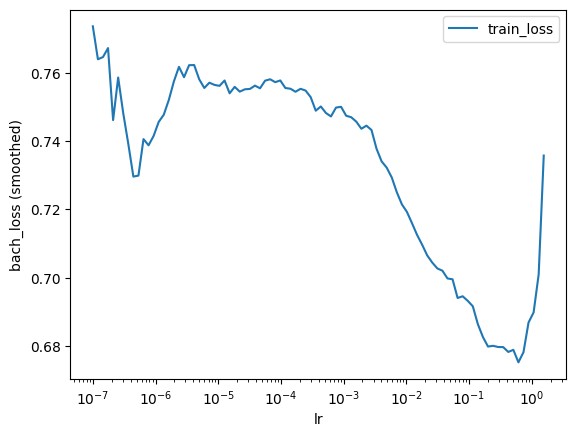

0:	[2s / 2s],		train_loss: 0.3874,	val_loss: 0.2019
1:	[2s / 5s],		train_loss: 0.1749,	val_loss: 0.1575
2:	[2s / 7s],		train_loss: 0.1342,	val_loss: 0.1294
3:	[2s / 10s],		train_loss: 0.1252,	val_loss: 0.1740
4:	[2s / 12s],		train_loss: 0.1313,	val_loss: 0.1396
5:	[2s / 15s],		train_loss: 0.1105,	val_loss: 0.1092
6:	[2s / 17s],		train_loss: 0.1050,	val_loss: 0.1069
7:	[2s / 20s],		train_loss: 0.1024,	val_loss: 0.1011
8:	[2s / 22s],		train_loss: 0.1011,	val_loss: 0.1167
9:	[2s / 24s],		train_loss: 0.0989,	val_loss: 0.1146
10:	[2s / 26s],		train_loss: 0.0958,	val_loss: 0.1027
11:	[2s / 29s],		train_loss: 0.0963,	val_loss: 0.0852
12:	[2s / 31s],		train_loss: 0.0988,	val_loss: 0.0937
13:	[2s / 34s],		train_loss: 0.0906,	val_loss: 0.1002
14:	[2s / 36s],		train_loss: 0.0947,	val_loss: 0.1001
15:	[2s / 39s],		train_loss: 0.0979,	val_loss: 0.0904
16:	[2s / 41s],		train_loss: 0.0890,	val_loss: 0.0910
17:	[2s / 44s],		train_loss: 0.0901,	val_loss: 0.0896
18:	[2s / 46s],		train_loss: 0.0885,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


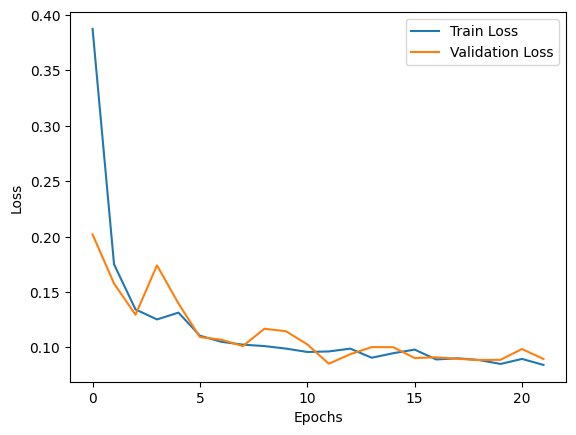

<ipython-input-8-206f93074544>:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_1.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 1):
C-index: 0.9790
IBS:     0.0329
NBLL:    0.1229
Random C-index: 0.4534
Random IBS:     0.4417
Random NBLL:    2.0029
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in trainval set.
Re

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


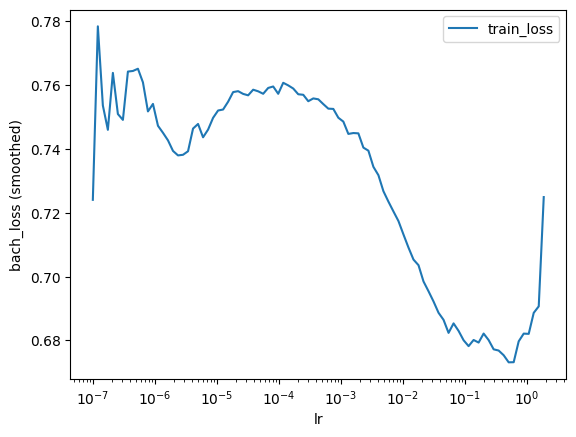

0:	[2s / 2s],		train_loss: 0.3786,	val_loss: 0.2261
1:	[2s / 5s],		train_loss: 0.1705,	val_loss: 0.1539
2:	[2s / 7s],		train_loss: 0.1338,	val_loss: 0.1334
3:	[2s / 10s],		train_loss: 0.1245,	val_loss: 0.1084
4:	[2s / 12s],		train_loss: 0.1130,	val_loss: 0.1198
5:	[2s / 15s],		train_loss: 0.1094,	val_loss: 0.1018
6:	[2s / 18s],		train_loss: 0.1037,	val_loss: 0.0949
7:	[2s / 20s],		train_loss: 0.1051,	val_loss: 0.1003
8:	[2s / 23s],		train_loss: 0.1015,	val_loss: 0.1003
9:	[2s / 25s],		train_loss: 0.0975,	val_loss: 0.1188
10:	[2s / 28s],		train_loss: 0.0971,	val_loss: 0.0949
11:	[2s / 30s],		train_loss: 0.0949,	val_loss: 0.0994
12:	[2s / 32s],		train_loss: 0.0932,	val_loss: 0.0957
13:	[2s / 35s],		train_loss: 0.0946,	val_loss: 0.0901
14:	[2s / 38s],		train_loss: 0.0932,	val_loss: 0.0956
15:	[2s / 40s],		train_loss: 0.0893,	val_loss: 0.0854
16:	[2s / 43s],		train_loss: 0.0915,	val_loss: 0.0876
17:	[2s / 45s],		train_loss: 0.0895,	val_loss: 0.1025
18:	[2s / 48s],		train_loss: 0.0908,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


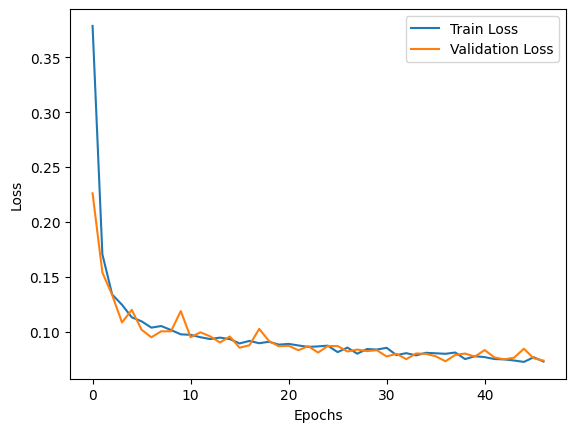

<ipython-input-8-206f93074544>:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


[✓] Saved fold results to tta_framewise_csvs/fold_2.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 2):
C-index: 0.9801
IBS:     0.0364
NBLL:    0.1555
Random C-index: 0.4509
Random IBS:     0.4412
Random NBLL:    1.9685
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


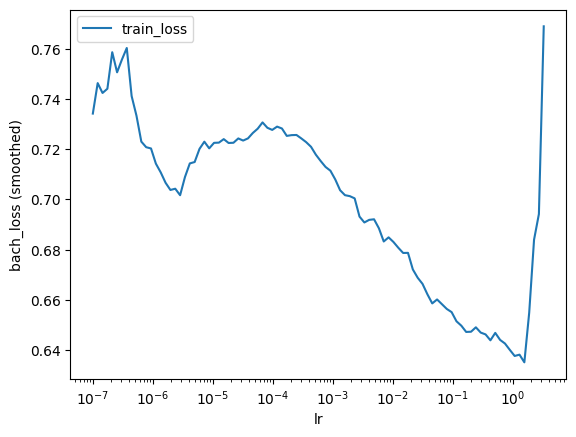

0:	[2s / 2s],		train_loss: 0.3663,	val_loss: 0.2119
1:	[2s / 5s],		train_loss: 0.1743,	val_loss: 0.1518
2:	[2s / 7s],		train_loss: 0.1314,	val_loss: 0.1429
3:	[2s / 10s],		train_loss: 0.1202,	val_loss: 0.1183
4:	[2s / 12s],		train_loss: 0.1117,	val_loss: 0.1084
5:	[2s / 15s],		train_loss: 0.1060,	val_loss: 0.1383
6:	[2s / 18s],		train_loss: 0.1039,	val_loss: 0.1050
7:	[2s / 20s],		train_loss: 0.1026,	val_loss: 0.0956
8:	[2s / 23s],		train_loss: 0.0991,	val_loss: 0.0989
9:	[2s / 25s],		train_loss: 0.0982,	val_loss: 0.1133
10:	[2s / 28s],		train_loss: 0.0930,	val_loss: 0.0992
11:	[2s / 30s],		train_loss: 0.0945,	val_loss: 0.0904
12:	[2s / 33s],		train_loss: 0.0921,	val_loss: 0.0913
13:	[2s / 35s],		train_loss: 0.0918,	val_loss: 0.0855
14:	[2s / 38s],		train_loss: 0.0913,	val_loss: 0.0851
15:	[2s / 40s],		train_loss: 0.0904,	val_loss: 0.0895
16:	[2s / 43s],		train_loss: 0.0868,	val_loss: 0.0843
17:	[2s / 45s],		train_loss: 0.0882,	val_loss: 0.0921
18:	[3s / 49s],		train_loss: 0.0854,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


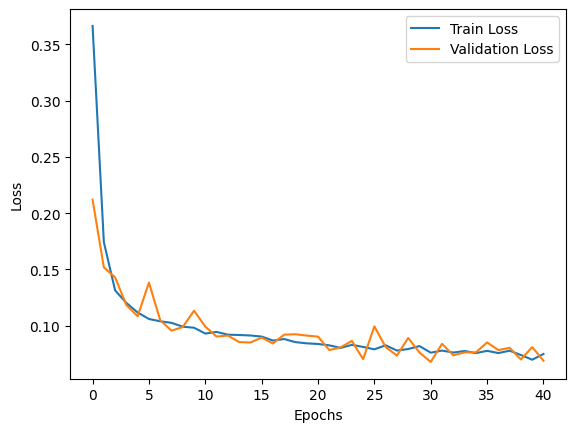

<ipython-input-8-206f93074544>:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


[✓] Saved fold results to tta_framewise_csvs/fold_3.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 3):
C-index: 0.9744
IBS:     0.0363
NBLL:    0.1577
Random C-index: 0.4530
Random IBS:     0.4407
Random NBLL:    1.9414
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


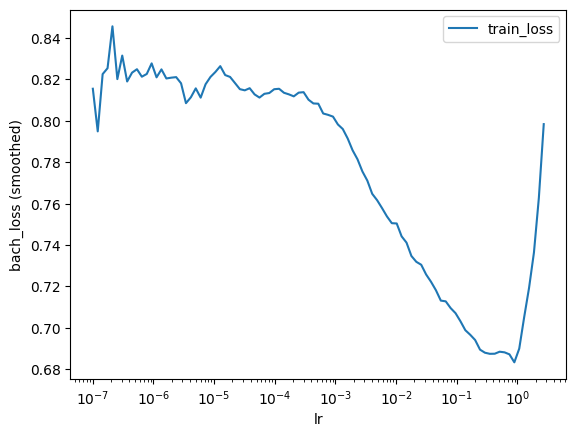

0:	[2s / 2s],		train_loss: 0.3792,	val_loss: 0.2471
1:	[2s / 4s],		train_loss: 0.1710,	val_loss: 0.1514
2:	[2s / 7s],		train_loss: 0.1384,	val_loss: 0.1528
3:	[2s / 9s],		train_loss: 0.1162,	val_loss: 0.1232
4:	[2s / 12s],		train_loss: 0.1120,	val_loss: 0.1148
5:	[2s / 14s],		train_loss: 0.1084,	val_loss: 0.0969
6:	[2s / 16s],		train_loss: 0.1051,	val_loss: 0.1622
7:	[2s / 19s],		train_loss: 0.0995,	val_loss: 0.1105
8:	[2s / 21s],		train_loss: 0.1010,	val_loss: 0.1361
9:	[2s / 24s],		train_loss: 0.0978,	val_loss: 0.1195
10:	[2s / 26s],		train_loss: 0.0936,	val_loss: 0.1445
11:	[2s / 29s],		train_loss: 0.0909,	val_loss: 0.1104
12:	[2s / 31s],		train_loss: 0.0913,	val_loss: 0.0971
13:	[2s / 34s],		train_loss: 0.0943,	val_loss: 0.0845
14:	[2s / 36s],		train_loss: 0.0927,	val_loss: 0.1071
15:	[2s / 39s],		train_loss: 0.0863,	val_loss: 0.0851
16:	[2s / 42s],		train_loss: 0.0894,	val_loss: 0.0873
17:	[2s / 44s],		train_loss: 0.0841,	val_loss: 0.1658
18:	[2s / 47s],		train_loss: 0.0878,	val_l

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


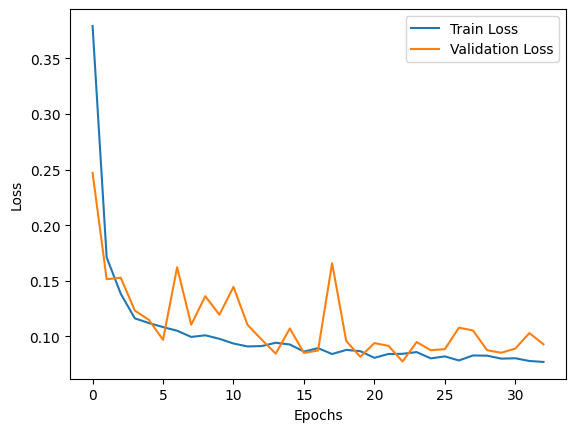

<ipython-input-8-206f93074544>:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


[✓] Saved fold results to tta_framewise_csvs/fold_4.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 4):
C-index: 0.9748
IBS:     0.0380
NBLL:    0.1440
Random C-index: 0.4456
Random IBS:     0.4435
Random NBLL:    1.9834
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 1 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 2 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 3 rows with adjusted_duration <= 0 in

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


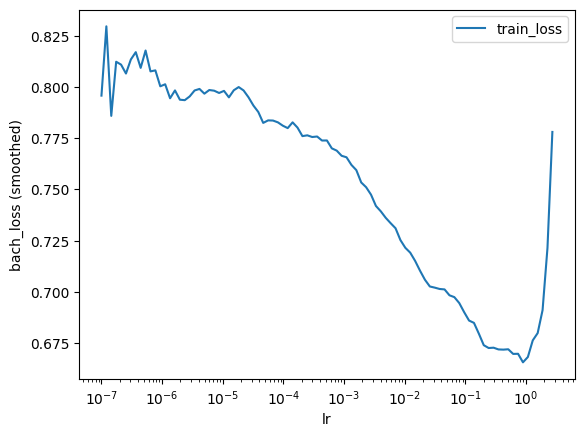

0:	[2s / 2s],		train_loss: 0.3852,	val_loss: 0.2255
1:	[2s / 5s],		train_loss: 0.1680,	val_loss: 0.1320
2:	[2s / 8s],		train_loss: 0.1319,	val_loss: 0.1500
3:	[2s / 10s],		train_loss: 0.1244,	val_loss: 0.1111
4:	[2s / 13s],		train_loss: 0.1135,	val_loss: 0.1185
5:	[2s / 15s],		train_loss: 0.1086,	val_loss: 0.1251
6:	[2s / 18s],		train_loss: 0.1108,	val_loss: 0.1020
7:	[2s / 20s],		train_loss: 0.0994,	val_loss: 0.1030
8:	[2s / 23s],		train_loss: 0.1001,	val_loss: 0.1163
9:	[2s / 26s],		train_loss: 0.1029,	val_loss: 0.1120
10:	[2s / 28s],		train_loss: 0.0957,	val_loss: 0.0945
11:	[2s / 31s],		train_loss: 0.0968,	val_loss: 0.1087
12:	[2s / 33s],		train_loss: 0.0955,	val_loss: 0.0942
13:	[2s / 36s],		train_loss: 0.0963,	val_loss: 0.0856
14:	[2s / 38s],		train_loss: 0.0879,	val_loss: 0.0869
15:	[2s / 41s],		train_loss: 0.0951,	val_loss: 0.1028
16:	[2s / 43s],		train_loss: 0.0910,	val_loss: 0.0990
17:	[2s / 46s],		train_loss: 0.0899,	val_loss: 0.0825
18:	[2s / 48s],		train_loss: 0.0919,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


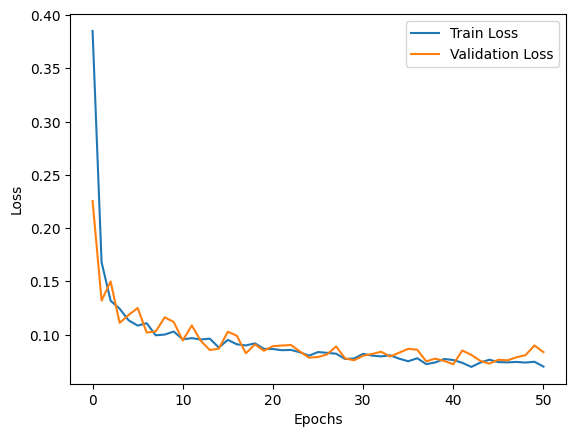

<ipython-input-8-206f93074544>:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


[✓] Saved fold results to tta_framewise_csvs/fold_5.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 5):
C-index: 0.9749
IBS:     0.0304
NBLL:    0.1138
Random C-index: 0.4251
Random IBS:     0.4420
Random NBLL:    1.9538
✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'
✅ Average metrics saved to 'average_evaluation_metrics.csv'


In [11]:
output_dir = "tta_framewise_csvs"
survival_curves = "survival_curves"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(survival_curves, exist_ok=True)
def process_and_collect_all_frames():
    all_true_times_folds, all_predicted_threshold_folds, all_predicted_ettc_folds = [], [], []
    for fold_id in range(1, 6):        
        all_X_train, all_X_val, all_y_train, all_y_val, test_data = [], [], [], [], []
        c_indices, ibs_scores, nbll_scores = [], [], []
        c_indices_random, ibs_scores_random, nbll_scores_random = [], [], []
        all_true_times, all_predicted_threshold, all_predicted_ettc = [], [], []
        
        fold_metrics = []


        fold_results = []  

        for frame_id in range(1, 51):  
            df_train, df_val, df_test = load_frame_data(fold_id, frame_id)

            
            if df_train is None:
                continue  

            X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_val, df_test)
            
            all_X_train.append(X_train)
            all_X_val.append(X_val)
            all_y_train.append(y_train)
            all_y_val.append(y_val)
            test_data.append((frame_id, X_test, y_test))

        
        X_train_all = np.concatenate(all_X_train)
        y_train_all = (np.concatenate([y[0] for y in all_y_train]), np.concatenate([y[1] for y in all_y_train]))

        X_val_all = np.concatenate(all_X_val)
        y_val_all = (np.concatenate([y[0] for y in all_y_val]), np.concatenate([y[1] for y in all_y_val]))

        model, labtrans = train_model(X_train_all, y_train_all, X_val_all, y_val_all)


        for frame_id, X_test, y_test in test_data:
            
            surv, c_index, ibs, nbll = evaluate_model(model, labtrans, X_test, y_test)
            c_index_random, ibs_random, nbll_random = evaluate_random_times(y_test)

            if surv is None:
                continue
                
            c_indices.append(c_index)
            ibs_scores.append(ibs)
            nbll_scores.append(nbll)
            c_indices_random.append(c_index_random)
            ibs_scores_random.append(ibs_random)
            nbll_scores_random.append(nbll_random)

            true_times_test = y_test[0].numpy()
            predicted_times_optimal = compute_predicted_times(surv, 0.5)
            predicted_times_ettc = compute_ettc(surv)


            correlation = np.corrcoef(true_times_test, predicted_times_ettc)[0, 1]

            for t, pt_thresh, pt_ettc in zip(true_times_test, predicted_times_optimal, predicted_times_ettc):
                fold_results.append({
                    'Frame_ID': frame_id,
                    'True_Time': t,
                    'Predicted_TTC_Threshold': pt_thresh,
                    'Predicted_ETTC': pt_ettc
                })

            all_true_times.extend(true_times_test)
            all_predicted_threshold.extend(predicted_times_optimal)
            all_predicted_ettc.extend(predicted_times_ettc)

        df_fold = pd.DataFrame(fold_results)
        fold_csv_path = os.path.join(output_dir, f'fold_{fold_id}.csv')
        df_fold.to_csv(fold_csv_path, index=False)
        print(f"[✓] Saved fold results to {fold_csv_path}")
        # Aggregate all fold predictions into global lists
        all_true_times_folds.extend(all_true_times)
        all_predicted_threshold_folds.extend(all_predicted_threshold)
        all_predicted_ettc_folds.extend(all_predicted_ettc)

        print("\n=== Final Aggregated Evaluation ===")
        if c_indices:
            mean_c_index = np.mean(c_indices)
            mean_ibs = np.mean(ibs_scores)
            mean_nbll = np.mean(nbll_scores)
        
            mean_c_index_random = np.mean(c_indices_random)
            mean_ibs_random = np.mean(ibs_scores_random)
            mean_nbll_random = np.mean(nbll_scores_random)
        
            print(f"\n📊 Final Aggregated Evaluation Metrics (Fold {fold_id}):")
            print(f"C-index: {mean_c_index:.4f}")
            print(f"IBS:     {mean_ibs:.4f}")
            print(f"NBLL:    {mean_nbll:.4f}")
            print(f"Random C-index: {mean_c_index_random:.4f}")
            print(f"Random IBS:     {mean_ibs_random:.4f}")
            print(f"Random NBLL:    {mean_nbll_random:.4f}")
        
            fold_metrics.append({
                'fold': fold_id,
                'c_index': mean_c_index,
                'ibs': mean_ibs,
                'nbll': mean_nbll,
                'c_index_random': mean_c_index_random,
                'ibs_random': mean_ibs_random,
                'nbll_random': mean_nbll_random
            })
        else:
            print("No valid frames for this fold.")

    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.to_csv("fold_evaluation_metrics.csv", index=False)

    avg_metrics = metrics_df.mean(numeric_only=True)
    avg_metrics_df = pd.DataFrame([avg_metrics])
    avg_metrics_df.to_csv("average_evaluation_metrics.csv", index=False)

    print("✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'")
    print("✅ Average metrics saved to 'average_evaluation_metrics.csv'")
    
    return (np.array(all_true_times_folds),
            np.array(all_predicted_threshold_folds),
            np.array(all_predicted_ettc_folds))

true_all, pred_thresh_all, pred_ettc_all = process_and_collect_all_frames()
true_times = np.array(true_all)  

# plot_combined_scatter(true_all, pred_thresh_all, pred_ettc_all)

In [12]:
np.random.seed(1234)
_ = torch.manual_seed(123)
random_preds = np.random.uniform(low=true_times.min(), high=true_times.max(), size=true_times.shape)

In [13]:
comparison_df = pd.DataFrame({
    'True_Time': true_all,
    'Pred_Threshold': pred_thresh_all,
    'Pred_ETTC': pred_ettc_all,
    'Random_Pred': random_preds
})

# Print full DataFrame
# print(comparison_df.to_string(index=False))
# Save DataFrame as CSV
comparison_df.to_csv("comparison_results.csv", index=False)
print("CSV file saved successfully.")

CSV file saved successfully.


In [14]:
import pandas as pd

# Load the CSV file
file_path = "comparison_results.csv"  # Replace with your actual file path
try:
    df = pd.read_csv(file_path)
    
    # Calculate the correlation matrix
    correlation_matrix = df[['True_Time', 'Pred_Threshold', 'Pred_ETTC', 'Random_Pred']].corr()
    
    # Print the correlation matrix
    print("\nCorrelation Coefficients:")
    print(correlation_matrix)
    
    # Save the correlation matrix to a CSV file
    correlation_matrix.to_csv("correlation_matrix.csv", index=True)
    print("\nCorrelation matrix saved as 'correlation_matrix.csv'.")
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path and try again.")



Correlation Coefficients:
                True_Time  Pred_Threshold  Pred_ETTC  Random_Pred
True_Time        1.000000        0.944018   0.946865     0.003105
Pred_Threshold   0.944018        1.000000   0.998111     0.003423
Pred_ETTC        0.946865        0.998111   1.000000     0.003349
Random_Pred      0.003105        0.003423   0.003349     1.000000

Correlation matrix saved as 'correlation_matrix.csv'.
